In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
import seaborn as sns

In [2]:
X,y = make_circles(n_samples=100, noise=0.1, random_state=1)

<Axes: >

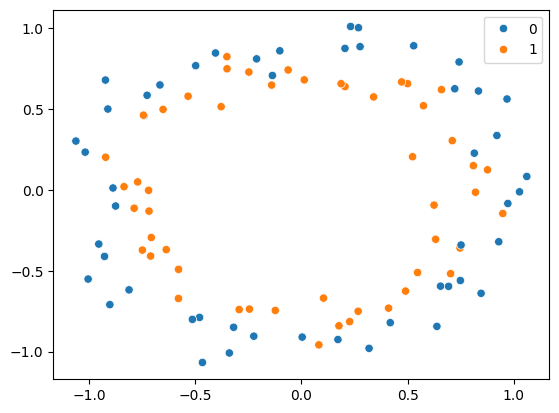

In [3]:
sns.scatterplot(x=X[:,0],y=X[:,1],hue=y)

In [4]:
X_train, X_test ,y_train,y_test = train_test_split(X,y, test_size=0.20, random_state=2)

In [5]:
import torch 
import torch.nn as nn
import torch.optim as optim

X_train_tensor = torch.from_numpy(X_train).float()  
y_train_tensor = torch.from_numpy(y_train).long()

X_test_tensor = torch.from_numpy(X_test).float()  # for class labels 
y_test_tensor = torch.from_numpy(y_test).long()

In [6]:
# wrapping in tensordata and dataloader class

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [7]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)



In [8]:
import torch.optim as optim 

train_losses = []
test_losses = []

def train_model(model, train_loader, test_loader, epochs=3500, lr=0.01):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for input_feature_batch, input_label_batch in train_loader:
            optimizer.zero_grad()
            preds = model(input_feature_batch)
            loss = loss_fn(preds, input_label_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            
        avg_train_loss = running_train_loss/ len(train_loader)
        train_losses.append(avg_train_loss)    
        
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for input_feature_batch,input_label_batch in test_loader:
                 preds = model(input_feature_batch)
                 loss = loss_fn(preds, input_label_batch)
                 running_test_loss += loss.item()
                 
        avg_test_loss = running_test_loss/ len(test_loader)
        test_losses.append(avg_test_loss)
        
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss}:.4f")        
                

In [9]:
y.shape

(100,)

In [10]:
X.shape[0]

100

In [11]:
input_size = X.shape[1]
num_classes = len(np.unique(y))

In [22]:
input_size

2

In [12]:
model = NN(input_size, num_classes)
train_model(model, train_loader, test_loader, epochs = 3500,lr=0.01)

Epoch 1: Train Loss = 0.7154, Test Loss = 0.698714554309845:.4f
Epoch 2: Train Loss = 0.6939, Test Loss = 0.7042616605758667:.4f
Epoch 3: Train Loss = 0.6939, Test Loss = 0.7057896852493286:.4f
Epoch 4: Train Loss = 0.6877, Test Loss = 0.7046301364898682:.4f
Epoch 5: Train Loss = 0.6833, Test Loss = 0.7035864591598511:.4f
Epoch 6: Train Loss = 0.6713, Test Loss = 0.7033025026321411:.4f
Epoch 7: Train Loss = 0.6736, Test Loss = 0.7075434327125549:.4f
Epoch 8: Train Loss = 0.6647, Test Loss = 0.7042317390441895:.4f
Epoch 9: Train Loss = 0.6549, Test Loss = 0.7016390562057495:.4f
Epoch 10: Train Loss = 0.6554, Test Loss = 0.7014471292495728:.4f
Epoch 11: Train Loss = 0.6561, Test Loss = 0.702425479888916:.4f
Epoch 12: Train Loss = 0.6471, Test Loss = 0.7036193609237671:.4f
Epoch 13: Train Loss = 0.6482, Test Loss = 0.7070733308792114:.4f
Epoch 14: Train Loss = 0.6327, Test Loss = 0.7088386416435242:.4f
Epoch 15: Train Loss = 0.6297, Test Loss = 0.7138310670852661:.4f
Epoch 16: Train Loss 

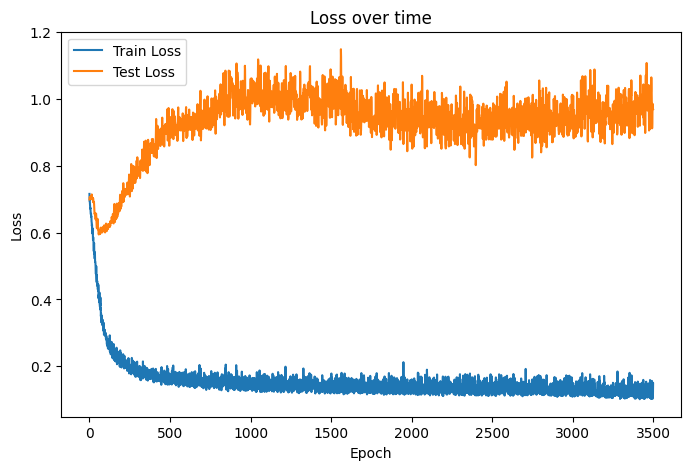

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over time")
plt.show()

In [14]:
'''
patience (int) : how many epochs to wait after last improvement
min_delta (float) : min change to qualify improvement
verbose (bool) : if true prints the message for each improvement
path (str) to save best model 

'''

'\npatience (int) : how many epochs to wait after last improvement\nmin_delta (float) : min change to qualify improvement\nverbose (bool) : if true prints the message for each improvement\npath (str) to save best model \n\n'

# early stopping implemented 

In [15]:


import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=False, path='checkpoint'):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path=path
        self.best_model_weight = None
        
    def __call__(self, val_loss, model):
        score = -val_loss   # bcz we want to minimize the loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
            
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                # if self.verbose:
                #     print("Early stopping triggered.")
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
            
    
    def save_checkpoint(self, model):
        ''' Saves model when val loss improves'''
        if self.verbose:
            print(f"Validation loss improved. Saving model to {self.path}")
        torch.save(model.state_dict(), self.path)

In [16]:
import torch.optim as optim 

train_losses = []
test_losses = []

def train_model(model, train_loader, test_loader, epochs=3500, lr=0.01, patience=350, min_delta=0.0):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    early_stopper = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for input_feature_batch, input_label_batch in train_loader:
            optimizer.zero_grad()
            preds = model(input_feature_batch)
            loss = loss_fn(preds, input_label_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            
        avg_train_loss = running_train_loss/ len(train_loader)
        train_losses.append(avg_train_loss)    
        
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for input_feature_batch,input_label_batch in test_loader:
                 preds = model(input_feature_batch)
                 loss = loss_fn(preds, input_label_batch)
                 running_test_loss += loss.item()
                 
        avg_test_loss = running_test_loss/ len(test_loader)
        test_losses.append(avg_test_loss)
        
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}") 
        
        early_stopper(avg_test_loss, model)
        
        if early_stopper.early_stop:
            print("Early stopping triggered , Training stopped")   
            break
        
    model.load_state_dict(torch.load(early_stopper.path))

In [17]:
input_size = X.shape[1]
num_classes = len(np.unique(y))

model = NN(input_size, num_classes)
train_model(model, train_loader, test_loader, epochs = 3500,lr=0.01 ,patience =300,min_delta=0.001)

Epoch 1: Train Loss = 0.7116, Test Loss = 0.7077
Validation loss improved. Saving model to checkpoint
Epoch 2: Train Loss = 0.6892, Test Loss = 0.7145
EarlyStopping counter: 1 / 300
Epoch 3: Train Loss = 0.6814, Test Loss = 0.7151
EarlyStopping counter: 2 / 300
Epoch 4: Train Loss = 0.6874, Test Loss = 0.7181
EarlyStopping counter: 3 / 300
Epoch 5: Train Loss = 0.6804, Test Loss = 0.7198
EarlyStopping counter: 4 / 300
Epoch 6: Train Loss = 0.6786, Test Loss = 0.7157
EarlyStopping counter: 5 / 300
Epoch 7: Train Loss = 0.6649, Test Loss = 0.7158
EarlyStopping counter: 6 / 300
Epoch 8: Train Loss = 0.6649, Test Loss = 0.7165
EarlyStopping counter: 7 / 300
Epoch 9: Train Loss = 0.6611, Test Loss = 0.7173
EarlyStopping counter: 8 / 300
Epoch 10: Train Loss = 0.6582, Test Loss = 0.7103
EarlyStopping counter: 9 / 300
Epoch 11: Train Loss = 0.6446, Test Loss = 0.7057
Validation loss improved. Saving model to checkpoint
Epoch 12: Train Loss = 0.6465, Test Loss = 0.7010
Validation loss improved

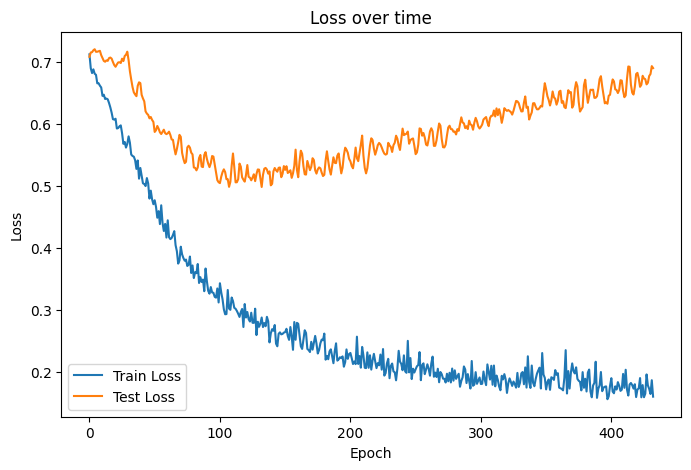

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over time")
plt.show()

In [21]:
from torchinfo import summary 

summary(model)

Layer (type:depth-idx)                   Param #
NN                                       --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       96
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       66
Total params: 162
Trainable params: 162
Non-trainable params: 0